In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d akash2907/bird-species-classification

Dataset URL: https://www.kaggle.com/datasets/akash2907/bird-species-classification
License(s): CC-BY-NC-SA-4.0
100% 1.37G/1.37G [01:24<00:00, 17.1MB/s]
100% 1.37G/1.37G [01:24<00:00, 17.5MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/bird-species-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [5]:

# Paths to the train and test directories
train_directory = '/content/train_data'
test_directory = '/content/test_data'

# Preprocess and augment training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Preprocess test/validation images
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories and resize them to 224x224
training_set = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 150 images belonging to 1 classes.
Found 157 images belonging to 1 classes.


In [6]:
# Load VGG16 model pre-trained on ImageNet, excluding the top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers to prevent updating during training
for layer in vgg16_base.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
# Build the final model
model = Sequential()

# Add the VGG16 base model
model.add(vgg16_base)

# Add a Flatten layer to convert 2D outputs to 1D
model.add(Flatten())

# Add a fully connected Dense layer
model.add(Dense(256, activation='relu'))

# Optionally add Dropout for regularization
model.add(Dropout(0.5))

# Output layer: Number of categories in the bird dataset (modify based on your dataset)
model.add(Dense(training_set.num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    training_set,
    epochs=20,  # Set the number of epochs as needed
    validation_data=test_set,
    callbacks=[early_stopping]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored

5/5 ━━━━━━━━━━━━━━━━━━━━ 94s 15s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test accuracy: {test_accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 1.0000 - loss: 0.0000e+00
Test accuracy: 1.0000


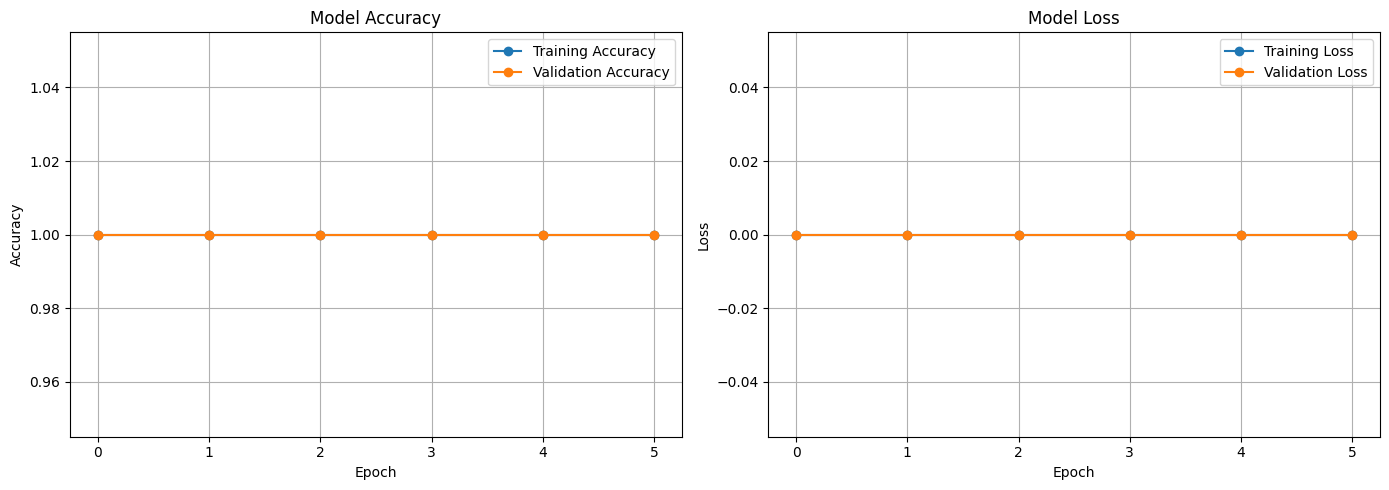

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

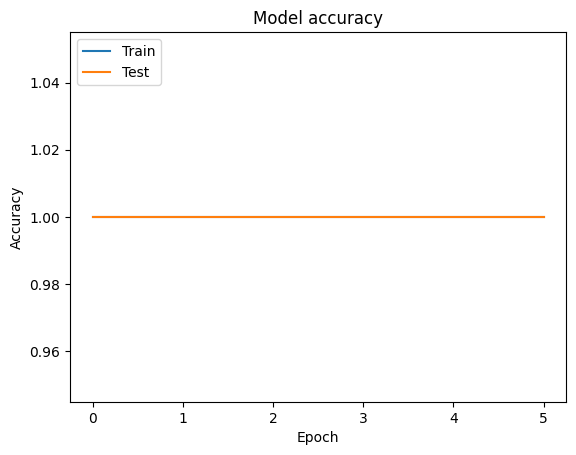

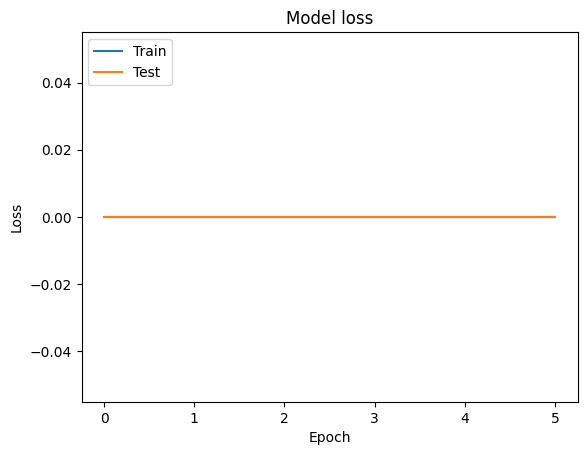

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


